<a href="https://colab.research.google.com/github/wyluoa/colab/blob/master/TW2884.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
# 等它安裝完成
!pip install yfinance > log.txt
!pip install Backtesting==0.2.0 > log.txt
!pip install talib-binary

In [53]:
import yfinance as yf
import pandas as pd

def get_historical_data(ticker):
  d = yf.Ticker(ticker)
  df = d.history(period="max")
  df.columns = df.columns.str.lower()
  df.columns = pd.Series(df.columns).str.capitalize().values
  return df.dropna()

df = get_historical_data('2884.TW')
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock splits
Date,,,,,,,
2002-01-29,2.44,2.51,2.44,2.49,50201101,0.0,0.0
2002-01-30,2.47,2.49,2.46,2.48,10894870,0.0,0.0
2002-02-01,2.54,2.55,2.51,2.53,14001723,0.0,0.0
2002-02-04,2.59,2.59,2.54,2.56,12291636,0.0,0.0
2002-02-05,2.57,2.57,2.53,2.54,7152680,0.0,0.0


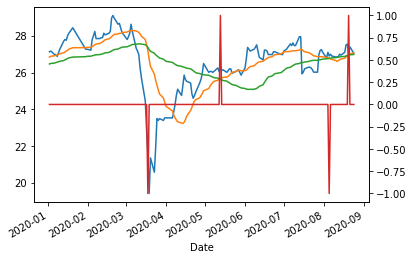

In [48]:
import talib

# compute simple moving average using talib
sma1 = talib.SMA(df.Close, timeperiod=20)
sma2 = talib.SMA(df.Close, timeperiod=60)

# compute buy and sell signals (golden cross and death cross)
signal_long = (sma1 > sma2) & (sma1.shift() < sma2.shift())
signal_short = (sma1 < sma2) & (sma1.shift() > sma2.shift())

# combine long and short signals
signal = signal_long.copy()
signal[signal_short] = -1

# plot
df.Close['2020'].plot()
sma1['2020'].plot()
sma2['2020'].plot()
signal['2020'].astype(int).plot(secondary_y=True)

In [49]:
from backtesting import Backtest, Strategy

class Strategy(Strategy):
    
    n1 = 20
    n2 = 60
    
    def init(self):
        super().init()
        
        # Precompute the two moving averages
        close = pd.Series(self.data.Close)
        sma1 = talib.SMA(close, timeperiod=self.n1)
        sma2 = talib.SMA(close, timeperiod=self.n2)

        # Precompute signal
        signal_long = (sma1 > sma2) & (sma1.shift() < sma2.shift())
        signal_short = (sma1 < sma2) & (sma1.shift() > sma2.shift())

        # combine signal
        signal = signal_long
        signal[signal_short] = -1
        
        # plot sma
        self.I(lambda x: sma1, 'sma1')
        self.I(lambda x: sma2, 'sma2')

        # set signal to trade
        self.signal = self.I(lambda x: signal, 'signal')

    def next(self):
        super().next()

        entry_size = self.signal[-1]

        if entry_size > 0:
            self.buy()
        elif entry_size < 0:
          for trade in self.trades:
              trade.close()

bt = Backtest(df, Strategy)
result1 = bt.run()
bt.plot()

In [50]:
result2 = bt.optimize(n1=range(5, 200, 10),
                      n2=range(5, 200, 10))
result2._strategy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Searching for best of 400 configurations.
  


<Strategy Strategy(n1=175,n2=125)>

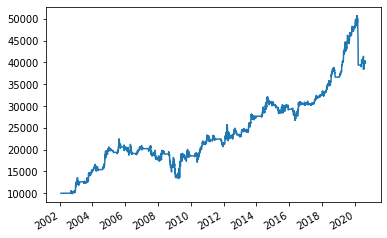

In [51]:
((result1._equity_curve.Equity + result2._equity_curve.Equity)/2).plot()